<a href="https://colab.research.google.com/github/aayushdD/Art-generation/blob/master/ArtGeneration_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os

In [ ]:
from google.colab import drive



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import glob
import cv2

In [ ]:
image_list=[]

In [ ]:
print(os.getcwd())
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
ll=os.walk(os.path.join(os.getcwd(),'drive\resized\resized'))

In [ ]:
for i , j , k in ll:
    path=i.split(os.sep)
    print(path)

In [ ]:
images=[]
for i , j , k in os.walk(os.path.join(os.getcwd(),'drive/MyDrive/resized/resized')):
    image_list=os.listdir(i)
    for image in image_list:
        instance=cv2.imread(os.path.join(i,image))
        ins=cv2.resize(instance,(128,128)).astype('float64')
        images.append(ins)
        
    
    

In [ ]:
images[0].shape

(128, 128, 3)

In [ ]:
import numpy as np

In [ ]:
len(images)

8683

In [ ]:
images[0].shape

(128, 128, 3)

In [ ]:
images[0]

array([[[30., 33., 42.],
        [25., 31., 41.],
        [34., 40., 52.],
        ...,
        [38., 19., 15.],
        [23., 10.,  5.],
        [11.,  5.,  3.]],

       [[30., 37., 49.],
        [31., 38., 52.],
        [28., 35., 52.],
        ...,
        [37., 17.,  9.],
        [32., 17.,  6.],
        [34., 19.,  9.]],

       [[28., 37., 51.],
        [24., 33., 47.],
        [27., 36., 50.],
        ...,
        [41., 22., 11.],
        [40., 20.,  9.],
        [39., 20.,  4.]],

       ...,

       [[ 5., 11., 24.],
        [11., 20., 33.],
        [15., 23., 37.],
        ...,
        [25., 33., 46.],
        [ 2., 10., 20.],
        [ 2.,  4., 11.]],

       [[ 3.,  8., 21.],
        [18., 30., 42.],
        [19., 29., 43.],
        ...,
        [ 7., 14., 26.],
        [ 5., 11., 22.],
        [ 1.,  3., 11.]],

       [[10., 16., 29.],
        [20., 32., 44.],
        [33., 43., 57.],
        ...,
        [ 6.,  8., 18.],
        [ 7.,  9., 18.],
        [ 5.,  3.,  9.]]

In [ ]:
discriminator=keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=4,strides=2, padding='same', input_shape=[128,128,3]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2D(128,kernel_size=4,strides=2,padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2D(256,kernel_size=4,strides=2,padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2D(512,kernel_size=4,strides=2,padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2D(1,kernel_size=1,strides=1,padding='valid',activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(1,activation='sigmoid')
   
])

In [ ]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0

In [ ]:
latent_size=1028
batch_size=32

In [ ]:

generator=keras.models.Sequential([
    # keras.layers.Conv2DTranspose(512,kernel_size=2,strides=2,padding='same', input_shape=[1,1,latent_size]),
    # keras.layers.BatchNormalization(),
    # keras.layers.LeakyReLU(),
   

    keras.layers.Conv2DTranspose(256,kernel_size=2,strides=2,padding='same',input_shape=[1,1,latent_size]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2DTranspose(128,kernel_size=2,strides=2,
                                padding='same'),
    keras.layers.BatchNormalization(),
   keras.layers.LeakyReLU(),
    
    keras.layers.Conv2DTranspose(64,kernel_size=2,strides=2,
                                padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2DTranspose(32,kernel_size=4,strides=4,
                                padding='same'),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2DTranspose(3,kernel_size=4,strides=4,
                                padding='same'),
    keras.layers.LeakyReLU()
    
])

In [ ]:
generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_27 (Conv2D  (None, 2, 2, 256)        1052928   
 Transpose)                                                      
                                                                 
 batch_normalization_19 (Bat  (None, 2, 2, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 2, 2, 256)         0         
                                                                 
 conv2d_transpose_28 (Conv2D  (None, 4, 4, 128)        131200    
 Transpose)                                                      
                                                                 
 batch_normalization_20 (Bat  (None, 4, 4, 128)        512       
 chNormalization)                                     

In [ ]:
generator.trainable_variables

In [ ]:
cross_entropy=keras.losses.BinaryCrossentropy()

In [ ]:
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

    

In [ ]:
def generator_loss(fake_output):
    gen_loss=cross_entropy(tf.ones_like(fake_output),fake_output)
    return gen_loss

In [ ]:
gen_opt=keras.optimizers.Adam()
dis_opt=keras.optimizers.Adam()
batch_size=32

In [ ]:
@tf.function
def train_step(images):
    noise=tf.random.normal([batch_size,1,1,latent_size])
    
    with tf.GradientTape() as gen_tape , tf.GradientTape() as dis_tape:
        gen_images=generator(noise,training=True)
        
        real_output=discriminator(images,training=True)
        fake_output=discriminator(gen_images,training=True)
        
        gen_loss=generator_loss(fake_output)
        dis_loss=discriminator_loss(real_output,fake_output)
        
    gen_gradients=gen_tape.gradient(gen_loss,generator.trainable_variables)
    dis_gradients=dis_tape.gradient(dis_loss,discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_gradients,generator.trainable_variables))
    dis_opt.apply_gradients(zip(dis_gradients,discriminator.trainable_variables))
    
    return gen_loss, dis_loss,gen_images[0]

In [ ]:
import time
from IPython import display

In [ ]:
def train_tot(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()      
    for image_batch in dataset:
      gen_loss,dis_loss,gen_img=train_step(image_batch)    
    print(gen_loss,dis_loss)
  return gen_img
    

In [ ]:

buffer=600

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices(images).shuffle(buffer).batch(batch_size)


In [ ]:
for element in dataset.take(1):
    print(element)

In [ ]:
vg=train_tot(dataset,150)

ValueError: ignored

In [ ]:
noise=generator(tf.random.normal([1,1,1,latent_size]),training=False)[0]

(7,)

In [ ]:
noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


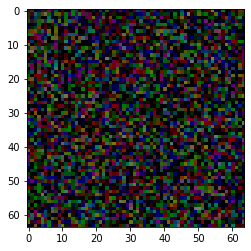

In [ ]:
import matplotlib.pyplot as plt
import sys
plt.imshow(np.array((noise*127.5)+127.5).astype(np.int8))

In [ ]:
nn=np.array((noise))

In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
os.getcwd()

'/content/drive/MyDrive'

In [ ]:
np.save(os.path.join(os.getcwd(),'gg'),nn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


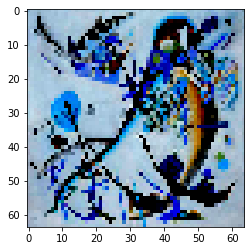

In [ ]:
plt.imshow(images[10])

In [ ]:
import cv2

In [ ]:
while True:
    cv2.imshow(noise)
    cv2.waitKey(0)
    sys.exit() # to exit from all the processes
 
cv2.destroyAllWindows() # destroy all windows

DisabledFunctionError: ignored